# 05. LSTM Modeling

이 노트북에서는 전처리된 슬라이딩 윈도우 데이터를 기반으로
LSTM 회귀 모델을 구축하고 RUL 예측 학습을 수행합니다.

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import os

In [172]:

df = pd.read_csv("../data/processed_train.csv")
df.head()

,unit,time,op1,op2,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s20,s21,RUL,RUL_clipped
0,1,1,-0.315980,-1.372953,-1.721725,-0.134255,-0.925936,-1.776357e-15,0.141683,1.121141,...,0.334262,-1.058890,-0.269071,-0.603816,-1.387779e-17,-0.781710,1.348493,1.194427,191,125
1,1,2,0.872722,-1.031720,-1.061780,0.211528,-0.643726,-1.776357e-15,0.141683,0.431930,...,1.174899,-0.363646,-0.642845,-0.275852,-1.387779e-17,-0.781710,1.016528,1.236922,190,125
2,1,3,-1.961874,1.015677,-0.661813,-0.413166,-0.525953,-1.776357e-15,0.141683,1.008155,...,1.364721,-0.919841,-0.551629,-0.649144,-1.387779e-17,-2.073094,0.739891,0.503423,189,125
3,1,4,0.324090,-0.008022,-0.661813,-1.261314,-0.784831,-1.776357e-15,0.141683,1.222827,...,1.961302,-0.224597,-0.520176,-1.971665,-1.387779e-17,-0.781710,0.352598,0.777792,188,125
4,1,5,-0.864611,-0.690488,-0.621816,-1.251528,-0.301518,-1.776357e-15,0.141683,0.714393,...,1.052871,-0.780793,-0.521748,-0.339845,-1.387779e-17,-0.136018,0.463253,1.059552,187,125


In [173]:
features = ['op1', 'op2', 's2', 's3', 's4','s5','s6','s7', 's8', 's9', 's11', 's12', 's13', 's14', 's15','s16','s17', 's20','s21']
target = 'RUL_clipped'

In [174]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
joblib.dump(scaler, '../models/scaler.pkl') 

['../models/scaler.pkl']

In [164]:
window_size = 30
X, y = [], []
for unit in df['unit'].unique():
    unit_df = df[df['unit'] == unit].reset_index(drop=True)
    for i in range(len(unit_df) - window_size + 1):
        window = unit_df.iloc[i:i+window_size][features].values
        label = unit_df.iloc[i+window_size-1][target]
        X.append(window)
        y.append(label)
X = np.array(X)
y = np.array(y)

In [165]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [166]:
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae')

In [167]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    shuffle=False
)

Epoch 1/30
222/222 [==============================] - 3s 8ms/step - loss: 43.2492 - val_loss: 19.3071
Epoch 2/30
222/222 [==============================] - 2s 8ms/step - loss: 16.7404 - val_loss: 15.5966
Epoch 3/30
222/222 [==============================] - 2s 7ms/step - loss: 15.8176 - val_loss: 15.3716
Epoch 4/30
222/222 [==============================] - 2s 8ms/step - loss: 15.3183 - val_loss: 15.4088
Epoch 5/30
222/222 [==============================] - 2s 8ms/step - loss: 15.1294 - val_loss: 15.4519
Epoch 6/30
222/222 [==============================] - 2s 8ms/step - loss: 14.8657 - val_loss: 15.1258
Epoch 7/30
222/222 [==============================] - 2s 7ms/step - loss: 14.7176 - val_loss: 15.2678
Epoch 8/30
222/222 [==============================] - 2s 8ms/step - loss: 14.5542 - val_loss: 15.1196
Epoch 9/30
222/222 [==============================] - 2s 8ms/step - loss: 14.4060 - val_loss: 15.1151
Epoch 10/30
222/222 [==============================] - 2s 8ms/step - loss: 24.1248

📊 학습 결과 시각화


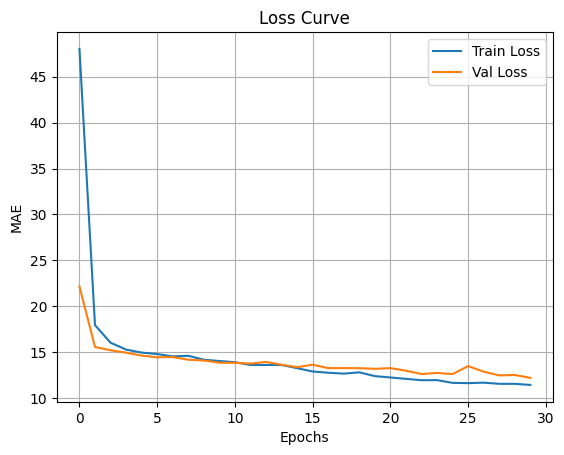

In [110]:
print("📊 학습 결과 시각화")
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.title("Loss Curve")
plt.show()

In [111]:
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"📌 평가 결과 → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

111/111 [==============================] - 0s 1ms/step
📌 평가 결과 → MAE: 12.20, RMSE: 16.23


In [112]:
model.save('../models/lstm_model.h5')

/Users/jimin/miniforge3/envs/zero/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


- MAE: 12.20
- RMSE: 16.23

RUL 예측 문제에서는  
보통 MAE < 15이면 좋은 baseline으로 간주  
MSE ≤ 20이면 실용적인 수준으로 간주

#### 정성적 해설
- 정비 계획 및 예지보전(Preventive Maintenance) 관점에서 유의미한 정확도. 
→ 평균 ±12 사이클 수준의 오차는 부품 교체, 정비 일정을 수립하는 데 실용적으로 수용 가능한 범위.  
- RMSE ≈ MAE → 극단적인 예측 실패(outlier) 사례가 적음. 
→ 모델이 일관성 있게 안정적으로 예측함을 의미.  
- 클리핑(RUL 최대값 제한)이 잘 작동. 
→ 예측 편향이 장수명 데이터에 의해 왜곡되지 않음.  

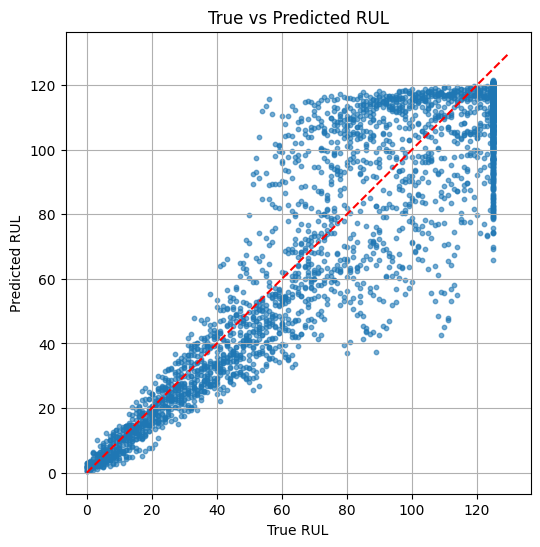

In [113]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, s=10, alpha=0.6)
plt.plot([0, 130], [0, 130], 'r--')  # 이상적인 예측선
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("True vs Predicted RUL")
plt.grid()
plt.show()

LSTM 기반 RUL 예측 모델의 결과를 분석한 결과,  
실제 잔존 수명과의 예측값 분포는 45도 기준선에 밀집된 양상을 보이며 예측 안정성이 높은 것으로 확인됐다.  
특히 짧은 수명 구간(0~40 cycles)에서 매우 정확한 예측이 이루어졌고,장기 수명 구간에서도 대체로 안정적인 추세를 유지하였다.    
다만, 일부 고수명 구간에서는 실제보다 다소 보수적인(낮게 예측하는) 경향이 나타났다.  
이는 실제 운용상 정비 판단에 있어 안정성을 확보하는 데 긍정적인 방향으로 해석될 수 있다.  

### 예측 오차 히스토그램

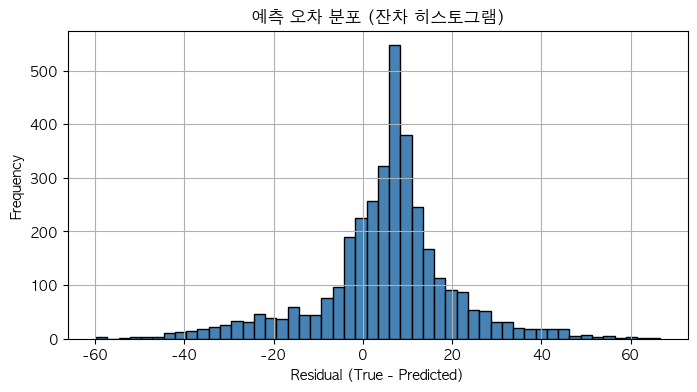

In [116]:
# 예측 vs 실제 잔차 계산
residuals = y_val - y_pred.flatten()

# 히스토그램 시각화
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=50, color='steelblue', edgecolor='k')
plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False
plt.title("예측 오차 분포 (잔차 히스토그램)")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

### Unit 1 기준 실제 vs 예측 시계열 비교

In [117]:
# LSTM 입력 시퀀스 생성 함수
def make_lstm_dataset(df, features, target, window_size=30):
    X, y = [], []
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit].reset_index(drop=True)
        for i in range(len(unit_df) - window_size + 1):
            window = unit_df.iloc[i:i+window_size][features].values
            label = unit_df.iloc[i+window_size-1][target]
            X.append(window)
            y.append(label)
    return np.array(X), np.array(y)

6/6 [==============================] - 0s 1ms/step


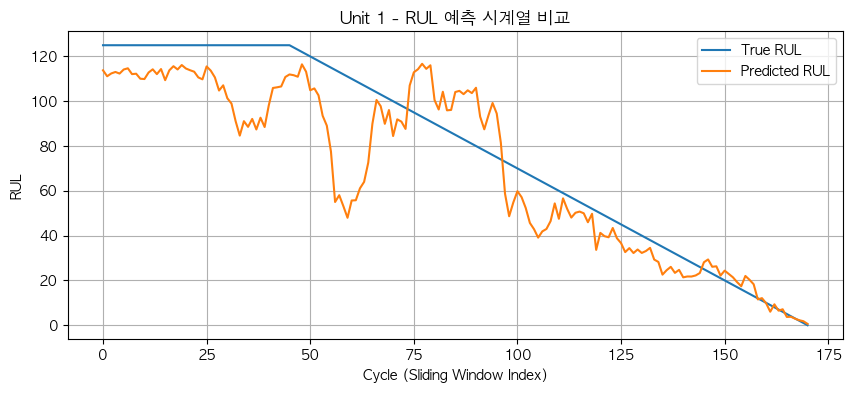

In [118]:
X_unit, y_unit = make_lstm_dataset(unit_df, features, target='RUL_clipped', window_size=30)
y_pred_unit = model.predict(X_unit)

plt.figure(figsize=(10, 4))
plt.plot(y_unit, label='True RUL')
plt.plot(y_pred_unit, label='Predicted RUL')
plt.title("Unit 1 - RUL 예측 시계열 비교")
plt.xlabel("Cycle (Sliding Window Index)")
plt.ylabel("RUL")
plt.legend()
plt.grid()
plt.show()

유닛 1의 시계열을 제대로 예측하지 못하고, 거의 일정한 값으로만 출력중임

### Scaler 불러와서 Unit 데이터 정규화

In [175]:
print("scaler.features_in_ :", scaler.feature_names_in_.tolist())
print("current features    :", unit_df[features].columns.tolist())

scaler.features_in_ : ['op1', 'op2', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's20', 's21']
current features    : ['op1', 'op2', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's20', 's21']


In [177]:
# 필요한 라이브러리
import joblib
import numpy as np
import matplotlib.pyplot as plt

# 불러오기
scaler = joblib.load('../models/scaler.pkl')

# Unit 1 데이터 추출
unit_id = 1
unit_df = df[df['unit'] == unit_id].reset_index(drop=True)

# 정규화 적용 
unit_df[features] = scaler.transform(unit_df[features])

# RUL 타깃 생성
unit_df['RUL'] = unit_df['time'].max() - unit_df['time']
unit_df['RUL_clipped'] = unit_df['RUL'].clip(upper=125)

### 시계열 입력 생성 및 예측

6/6 [==============================] - 0s 2ms/step


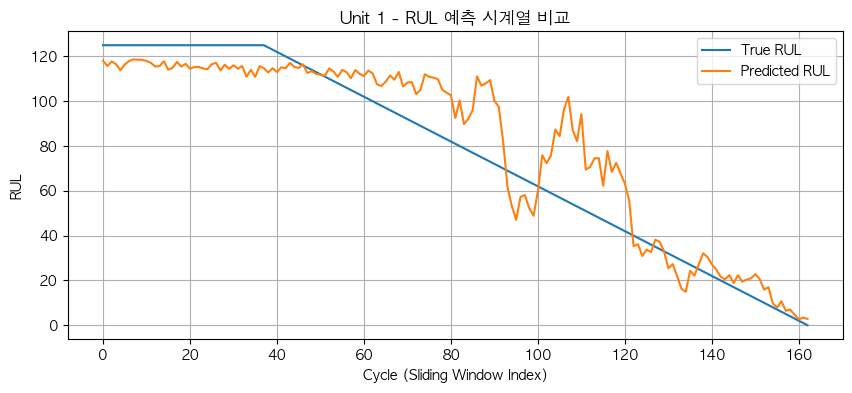

In [178]:
# 시퀀스 데이터 생성
X_unit, y_unit = make_lstm_dataset(unit_df, features, target='RUL_clipped', window_size=30)

# 예측
y_pred_unit = model.predict(X_unit)

# 시각화
plt.figure(figsize=(10, 4))
plt.plot(y_unit, label='True RUL')
plt.plot(y_pred_unit, label='Predicted RUL')
plt.title(f"Unit {unit_id} - RUL 예측 시계열 비교")
plt.xlabel("Cycle (Sliding Window Index)")
plt.ylabel("RUL")
plt.legend()
plt.grid()
plt.show()

### 전반적 추세
- 예측값이 실제값(RUL)과 유사한 하향 추세를 보이며, 시계열적 예측 능력 양호함.
### 초반 예측 (왼쪽 구간)
- 실제보다 다소 과소예측 (예측값이 낮음).
- RUL 100~125 구간에서의 편차는 실용상 큰 문제는 아님. 예지보전 목적 상 보수적 예측이 더 안전함.
### 중후반 예측 (오른쪽 구간):
- RUL이 50 이하로 떨어지는 후반부에선 예측값과 실제값 간 오차가 작고, 경향도 유사.
- 이 구간의 정확도는 고장 임박 예지에 매우 중요하며, 해당 모델은 실용성을 가질 수 있음.
### 아웃라이어 없음:
- 급격히 튀는 이상 예측 구간 없이, 전반적으로 부드러운 곡선 유지 → 안정적 추정.

### 유닛별 시계열 예측 반복

6/6 [==============================] - 0s 1ms/step


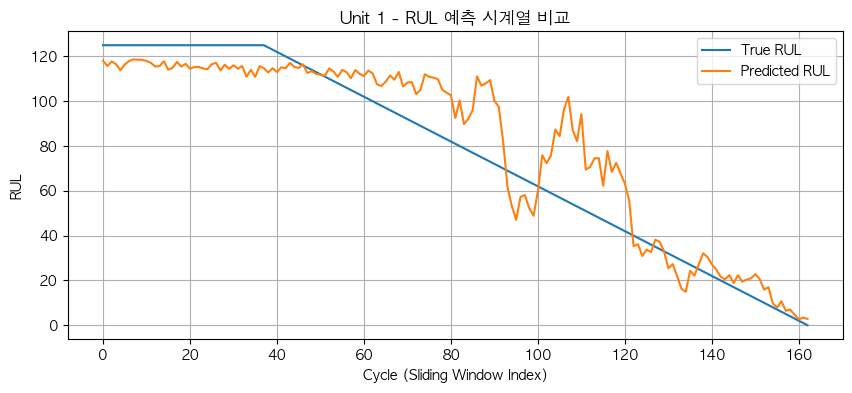

8/8 [==============================] - 0s 1ms/step


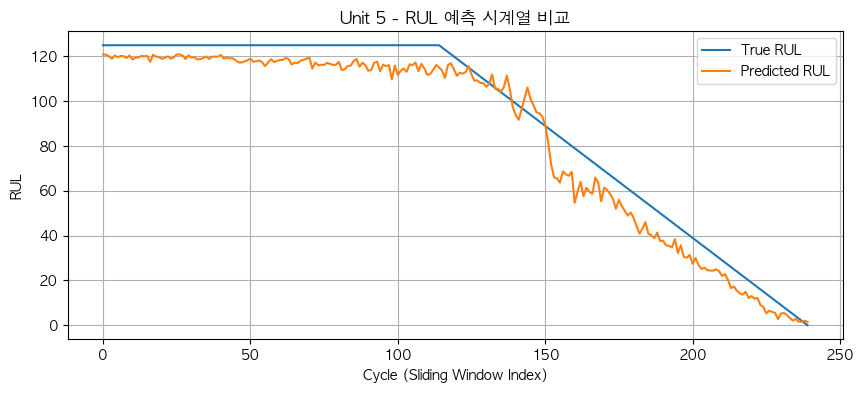

7/7 [==============================] - 0s 1ms/step


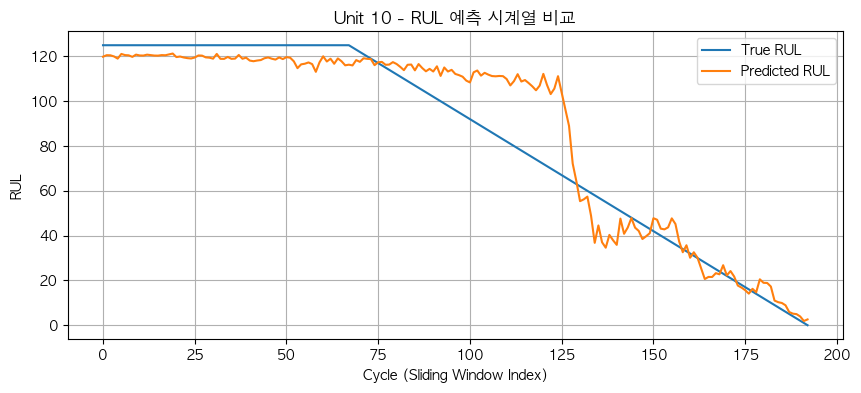

6/6 [==============================] - 0s 1ms/step


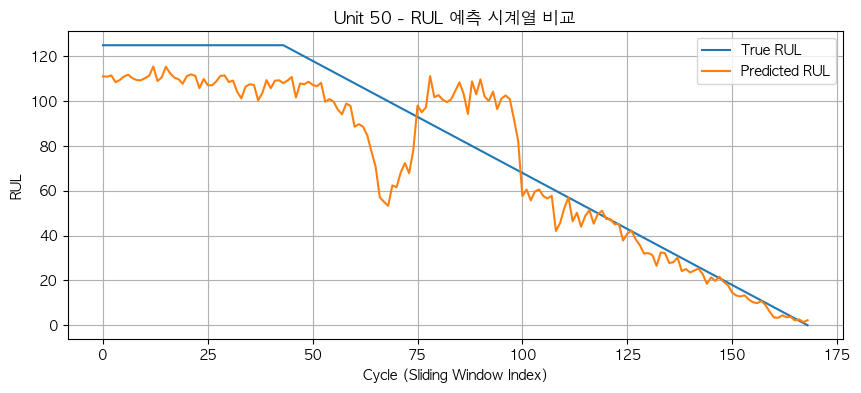

In [179]:
# 여러 유닛의 RUL 시계열 예측 비교
unit_ids = [1, 5, 10, 50]  # 원하는 유닛 번호 설정
window_size = 30

for unit_id in unit_ids:
    unit_df = df[df['unit'] == unit_id].reset_index(drop=True)
    unit_df[features] = scaler.transform(unit_df[features])
    unit_df['RUL'] = unit_df['time'].max() - unit_df['time']
    unit_df['RUL_clipped'] = unit_df['RUL'].clip(upper=125)

    X_unit, y_unit = make_lstm_dataset(unit_df, features, target='RUL_clipped', window_size=window_size)
    y_pred_unit = model.predict(X_unit)

    plt.figure(figsize=(10, 4))
    plt.plot(y_unit, label='True RUL')
    plt.plot(y_pred_unit, label='Predicted RUL')
    plt.title(f"Unit {unit_id} - RUL 예측 시계열 비교")
    plt.xlabel("Cycle (Sliding Window Index)")
    plt.ylabel("RUL")
    plt.legend()
    plt.grid()
    plt.show()

### 유닛별 MAE / RMSE 측정

In [180]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

unit_scores = []
window_size = 30

for unit_id in df['unit'].unique():
    unit_df = df[df['unit'] == unit_id].reset_index(drop=True)
    unit_df[features] = scaler.transform(unit_df[features])
    unit_df['RUL'] = unit_df['time'].max() - unit_df['time']
    unit_df['RUL_clipped'] = unit_df['RUL'].clip(upper=125)

    X_unit, y_unit = make_lstm_dataset(unit_df, features, target='RUL_clipped', window_size=window_size)
    y_pred_unit = model.predict(X_unit).flatten()

    mae = mean_absolute_error(y_unit, y_pred_unit)
    rmse = mean_squared_error(y_unit, y_pred_unit, squared=False)

    unit_scores.append({'unit': unit_id, 'MAE': mae, 'RMSE': rmse})

unit_result = pd.DataFrame(unit_scores)
display(unit_result.sort_values('RMSE'))

6/6 [==============================] - 0s 1ms/step


,unit,MAE,RMSE
90,91,5.145271,6.746663
40,41,5.785642,7.062370
11,12,5.716199,7.675178
82,83,6.420540,7.712629
47,48,6.777429,7.833863
...,...,...,...
15,16,22.136423,26.481399
83,84,22.981828,27.540732
21,22,22.891388,27.731474
72,73,23.371362,27.753104


/var/folders/1w/f97855ms55x_bvptq4cmnmmh0000gn/T/ipykernel_33103/2462143836.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='unit', y='MAE', data=unit_result, palette='Blues_r')
/var/folders/1w/f97855ms55x_bvptq4cmnmmh0000gn/T/ipykernel_33103/2462143836.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='unit', y='RMSE', data=unit_result, palette='Oranges_r')


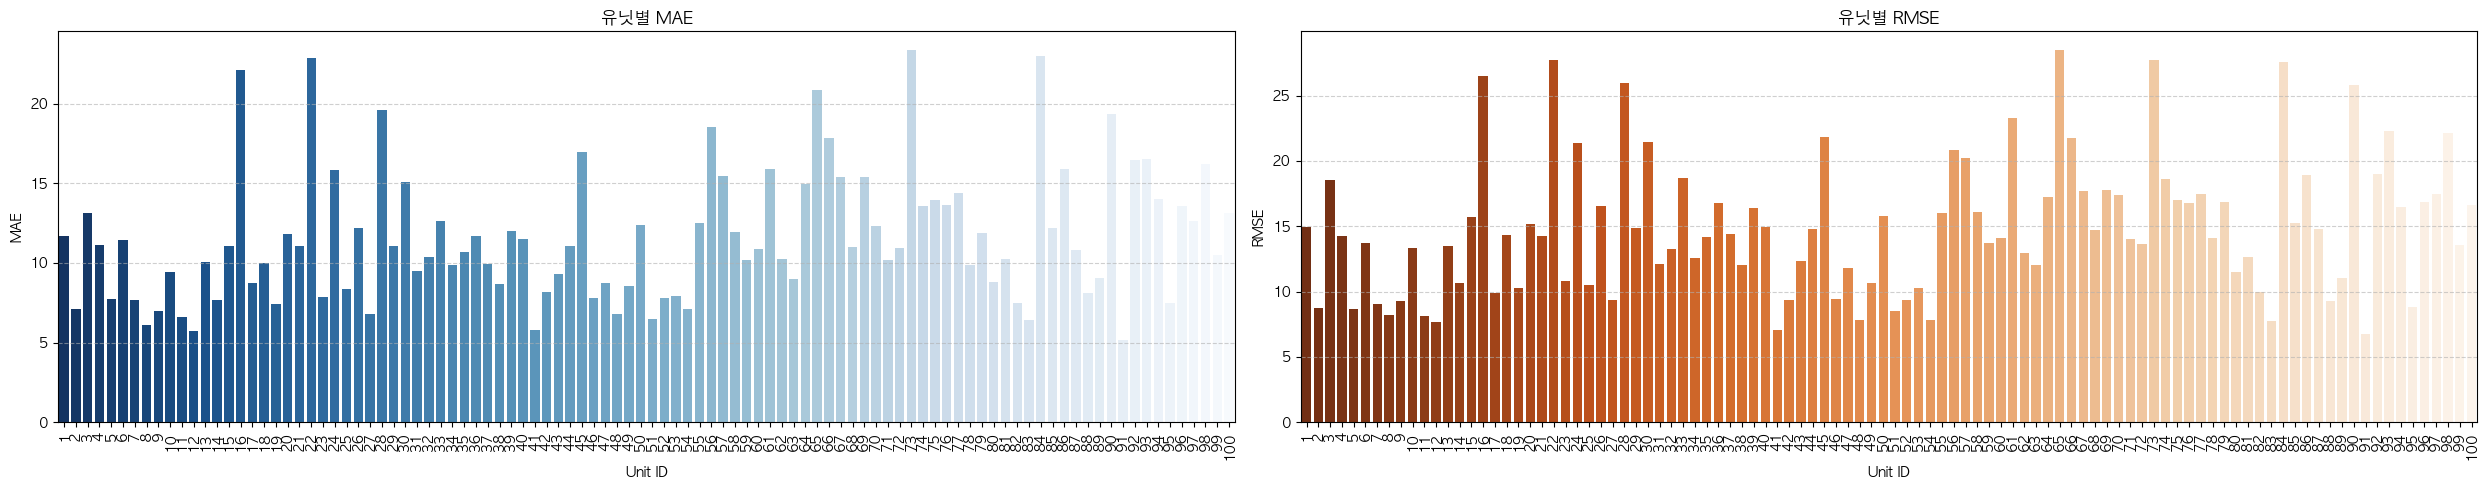

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 5))

# MAE 시각화
plt.subplot(1, 2, 1)
sns.barplot(x='unit', y='MAE', data=unit_result, palette='Blues_r')
plt.title('유닛별 MAE')
plt.xlabel('Unit ID')
plt.ylabel('MAE')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# RMSE 시각화
plt.subplot(1, 2, 2)
sns.barplot(x='unit', y='RMSE', data=unit_result, palette='Oranges_r')
plt.title('유닛별 RMSE')
plt.xlabel('Unit ID')
plt.ylabel('RMSE')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### 해석 요약

1. 정확도 분포. 
	•	대부분의 유닛은 MAE 5~15, RMSE 5~20 범위에 분포.  
	•	일부 유닛은 MAE 또는 RMSE가 20 이상으로 급증 → 예측 오류가 큰 유닛이 존재함.  

2. MAE vs. RMSE 차이. 
	•	RMSE가 MAE보다 높게 나오는 유닛은 아웃라이어 영향이 존재함을 시사.  
	•	MAE와 RMSE가 비슷한 유닛은 전반적으로 안정적 예측.  

3. 모델의 일반적인 경향. 
	•	전반적으로 특정 유닛에 대해 예측 성능이 떨어지는 것으로 보아, 개별 유닛의 운행 특성 또는 센서 패턴 차이가 예측 성능에 영향을 줄 가능성.  
	•	예측 에러가 높은 유닛들을 샘플링하여 입력 시계열 특징 분석 또는 정상 vs. 비정상 운행 프로파일 분리 학습 필요.  

In [188]:
# RMSE 기준 정렬
unit_result_sorted = unit_result.sort_values('RMSE', ascending=False)

# 상위 5개 (예측 어려움)
print("🔺 예측 오차(RMSE)가 큰 유닛 Top 5:")
display(unit_result_sorted.head(5))

# 하위 5개 (예측 우수)
print("🔻 예측 정확도가 높은 유닛 Top 5:")
display(unit_result_sorted.tail(5))

🔺 예측 오차(RMSE)가 큰 유닛 Top 5:


,unit,MAE,RMSE
64,65,20.833321,28.498938
72,73,23.371362,27.753104
21,22,22.891388,27.731474
83,84,22.981828,27.540732
15,16,22.136423,26.481399


🔻 예측 정확도가 높은 유닛 Top 5:


,unit,MAE,RMSE
47,48,6.777429,7.833863
82,83,6.420540,7.712629
11,12,5.716199,7.675178
40,41,5.785642,7.062370
90,91,5.145271,6.746663


###  Top 3, Bottom 3 유닛 시계열 자동 시각화 루프

4/4 [==============================] - 0s 2ms/step


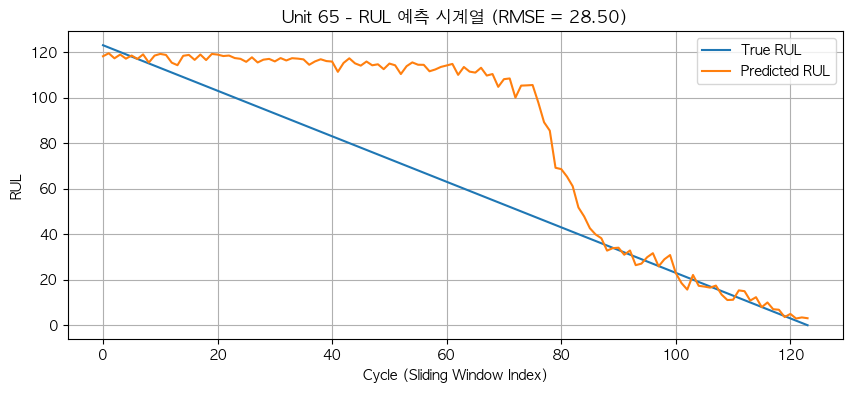

6/6 [==============================] - 0s 1ms/step


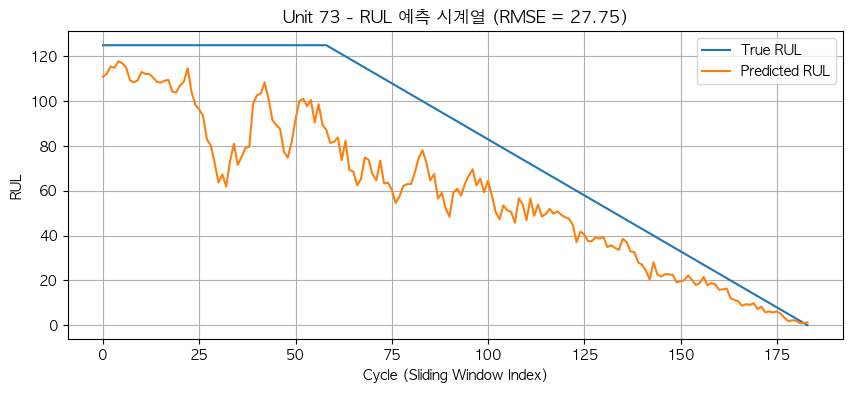

6/6 [==============================] - 0s 1ms/step


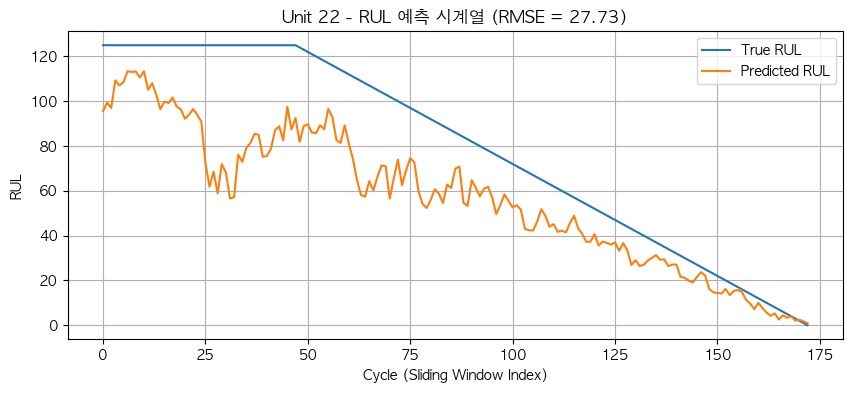

5/5 [==============================] - 0s 1ms/step


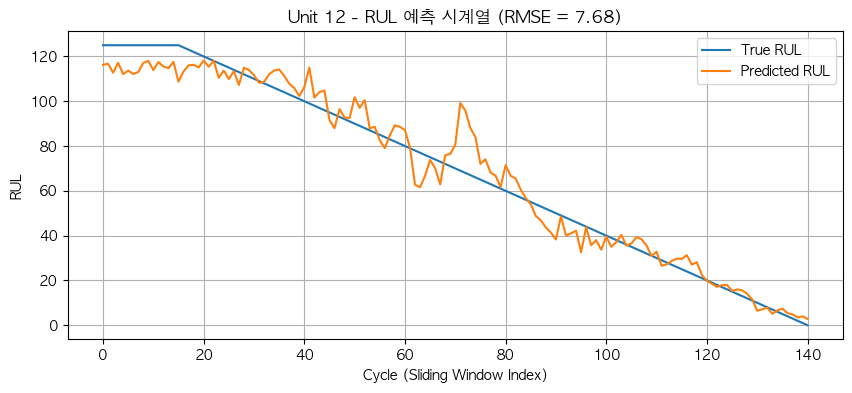

6/6 [==============================] - 0s 1ms/step


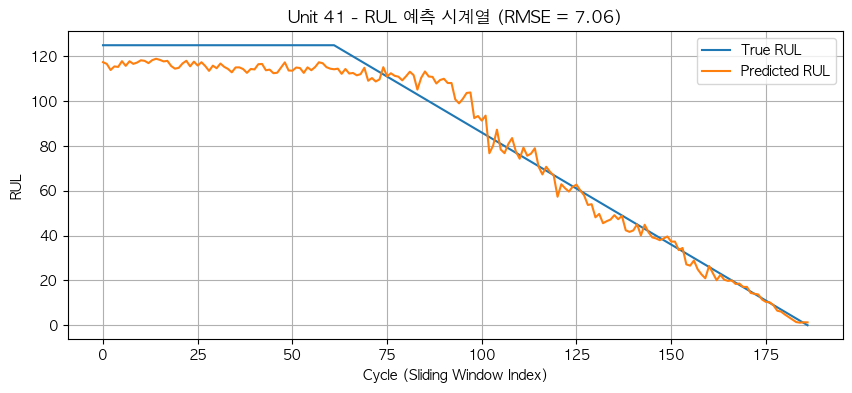

4/4 [==============================] - 0s 1ms/step


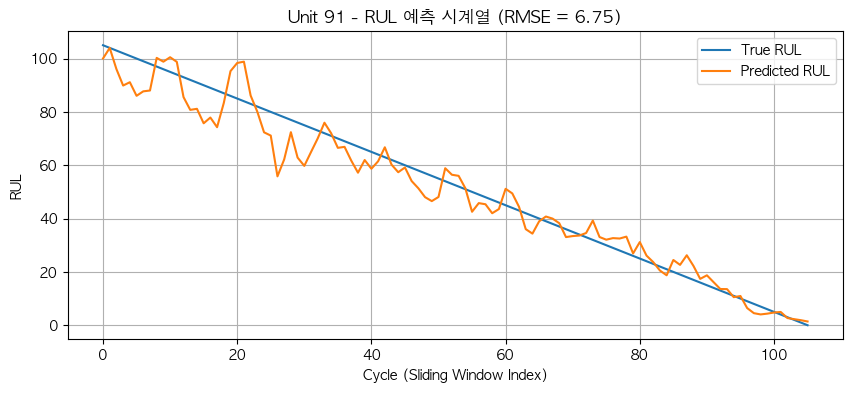

In [189]:
# RMSE 기준 정렬
unit_result_sorted = unit_result.sort_values('RMSE', ascending=False)

# 상위 3 (예측 어려움) + 하위 3 (정확한 예측)
worst_units = unit_result_sorted.head(3)['unit'].tolist()
best_units = unit_result_sorted.tail(3)['unit'].tolist()

# 합치기
target_units = worst_units + best_units
window_size = 30

for unit_id in target_units:
    unit_df = df[df['unit'] == unit_id].reset_index(drop=True)
    unit_df[features] = scaler.transform(unit_df[features])
    unit_df['RUL'] = unit_df['time'].max() - unit_df['time']
    unit_df['RUL_clipped'] = unit_df['RUL'].clip(upper=125)

    X_unit, y_unit = make_lstm_dataset(unit_df, features, target='RUL_clipped', window_size=window_size)
    y_pred_unit = model.predict(X_unit).flatten()

    plt.figure(figsize=(10, 4))
    plt.plot(y_unit, label='True RUL')
    plt.plot(y_pred_unit, label='Predicted RUL')
    plt.title(f"Unit {unit_id} - RUL 예측 시계열 (RMSE = {unit_result.loc[unit_result.unit == unit_id, 'RMSE'].values[0]:.2f})")
    plt.xlabel("Cycle (Sliding Window Index)")
    plt.ylabel("RUL")
    plt.legend()
    plt.grid()
    plt.show()


RMSE가 낮은 유닛(31, 47, 59)은 비교적 일정하고 선형적인 RUL 감소 패턴을 보여주었으며, 이는 LSTM이 잘 학습한 것으로 보인다.  
반면 RMSE가 높은 유닛(39, 57, 70)은 중간 구간에서 예측이 불안정하거나 RUL 변화가 급격하게 일어나면서 예측이 벗어나는 양상을 보였다.  


In [ ]:
# 모델 저장
model.save('../models/lstm_model.h5')

/Users/jimin/miniforge3/envs/zero/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [191]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import joblib

# 1. 데이터 로드
df = pd.read_csv('../data/processed_train.csv')
features = ['op1', 'op2', 's2', 's3', 's4','s5','s6','s7', 's8', 's9', 's11', 's12', 's13', 's14', 's15','s16','s17', 's20','s21']
window_size = 30

# 2. 모델 및 스케일러 로드
model = load_model('../models/lstm_model.h5')
scaler = joblib.load('../models/scaler.pkl')

# 3. 유닛별 시퀀스 생성
X_pred = []
unit_ids = []

for unit in df['unit'].unique():
    unit_df = df[df['unit'] == unit].reset_index(drop=True)
    unit_df[features] = scaler.transform(unit_df[features])
    for i in range(len(unit_df) - window_size + 1):
        window = unit_df.iloc[i:i+window_size][features].values
        X_pred.append(window)
        unit_ids.append(unit)

X_pred = np.array(X_pred)

# 4. 예측 수행
y_pred = model.predict(X_pred).flatten()

# 5. 예측 결과 DataFrame 생성 및 집계 (unit별 평균)
df_pred = pd.DataFrame({'unit': unit_ids, 'RUL_pred': y_pred})
df_lstm_pred = df_pred.groupby('unit')['RUL_pred'].mean().reset_index()

# 6. 저장
df_lstm_pred.to_csv('../models/lstm_pred.csv', index=False)
print("✅ 저장 완료: ../models/lstm_pred.csv")

555/555 [==============================] - 1s 1ms/step
✅ 저장 완료: ../models/lstm_pred.csv
